#### Problem Statement

The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.

Suppose you are working as a Machine Learning Engineer/Data Scientist in an e-commerce company named 'E-Com'. E-Com has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

With the advancement in technology, it is imperative for E-Com to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a Data Scientis/ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings.

In order to do this, you planned to build a sentiment-based product recommendation system, which includes the following tasks.

Data sourcing and sentiment analysis Building a recommendation system Improving the recommendations using the sentiment analysis model Deploying the end-to-end project with a user interface


### High Level steps 

* Data Sourcing and Sentiment Analysis

* Building a recommendation system

* Improving the recommendation system using sentiment analysis model

* Deploying the end-to-end project with user interface


In [16]:
# !pip install pyspellchecker

In [355]:
# Import general purpose libraries 
import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import warnings
import pickle

# Import Pre-Processing Tools
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
warnings.filterwarnings("ignore") 

# Set Pandas options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)
pd.set_option("display.precision", 2)


#Helper Functions
from utils import (
    clean_stopwords,
    clean_punctuation, 
    calc_missing_rowcount    
)


In [ ]:
# nltk packages
import nltk
import ssl

""" Download all nltk packages through external ssl"""
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')



In [10]:
# nltk libraries
from nltk.corpus import stopwords 
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn

In [347]:
# ML Modelling Libraries

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [24]:
# import sklearn
# print(sklearn.__version__) #1.0.2
# print(np.__version__) #1.22.4
# print(pd.__version__) #1.3.5
# print(nltk.__version__) #3.8.1

In [107]:
import os
cwd = os.getcwd()
df_reviews = pd.read_csv(cwd + "/user_reviews.csv", parse_dates= ['reviews_date'])
df_reviews.shape

(30000, 15)

In [117]:
df_reviews.sample(1)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
29575,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday Shop,Christmas,Featured Brands,Health & Beauty,L'oreal,Personal Care,Hair Treatments,Conditioner",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,2017-01-25T16:57:13.000Z,NaN,True,4,"Great conditioner in general with quality on par w/ L'Oreal brand. I wish it was as effective as it claims to be since I was so excited to try it thanks to Influenster. I have sensitive hair with oily roots and dry ends from curling iron, blow dryer, etc. So I was expecting this to work and save...",Smells Great; A Little Goes A Long Way!,Yonkers,NaN,skyy,Positive


In [118]:
#Inspect the dataframe to understand the given data
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

* There are many columns with NULL values, we will handle them later.
* First step is to eliminate some columns as part of our analysis for Sentiment and Recommender models.We will inspect them and remove them later.

### Exploratory Data Analysis(EDA) - Data Cleaning and Pre-Processing

In [120]:
def calc_missing_rowcount(df):
    columns = df.columns
    null_count = [df[col].isnull().sum() for col in columns]
    null_perc = [round((val/df.shape[0]) * 100,2) for val in null_count]
    _df = pd.DataFrame({'Columns':np.array(columns),
                        'Count': np.array(null_count),
                        'Percent':np.array(null_perc)})
    # If round is not an option, formatting options in pandas and numpy will 
    # pd.options.display.float_format = '{:.2f}'.format
    # np.set_printoptions(suppress=True)
                            
    return _df.sort_values("Percent",ascending=False)
calc_missing_rowcount(df_reviews)



,Columns,Count,Percent
12,reviews_userProvince,29830,99.43
11,reviews_userCity,28071,93.57
6,reviews_didPurchase,14068,46.89
7,reviews_doRecommend,2570,8.57
10,reviews_title,190,0.63
3,manufacturer,141,0.47
13,reviews_username,63,0.21
5,reviews_date,46,0.15
0,id,0,0.00
1,brand,0,0.00


#### Observations:
**reviews_userProvince** and **reviews_userCity** have over 93% NULL values and are not useful for analysis. We will remove them from the dataset.

**reviews_didPurchase** column has over 46% NULL values. This field is not useful in building either Sentiment/Recommender system as well and will be removed.

Removing reviews_userProvince, reviews_userCity and reviews_didPurchase from the dataset¶


In [121]:
df_clean = df_reviews.copy()
df_clean.drop(columns=['reviews_userProvince','reviews_userCity','reviews_didPurchase'],
                inplace=True)
df_clean.shape

(30000, 12)

Checking reviews_doRecommend column¶


In [122]:
print(df_clean.reviews_doRecommend.value_counts()
)
print(df_clean.reviews_doRecommend.value_counts(normalize=True)
)

True     25880
False     1550
Name: reviews_doRecommend, dtype: int64
True    0.94
False   0.06
Name: reviews_doRecommend, dtype: float64


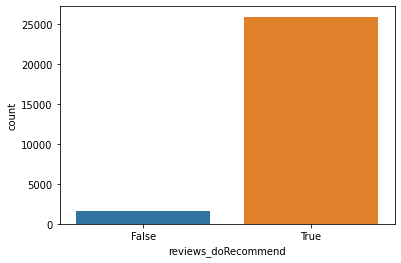

In [123]:
sns.countplot(x = 'reviews_doRecommend', data = df_clean)
plt.show()

Looking at the distribution of reviews_doRecommend column, we can see that more than 94% of the data is having True value. Hence, the column does not provide any useful information for the model to learn. We will drop this field

In [124]:
df_clean.drop(columns=['reviews_doRecommend'], inplace=True)


In [125]:
df_clean.shape

(30000, 11)

**Handling NULL values in reviews_title**

This column is an important component for our analysis as it contains the title of the review given by the user to a particular product. Since the NULL percentage is only 0.633%, we will remove these rows from the dataset.





In [126]:
df_clean = df_clean[~ df_clean.reviews_title.isna() ]
df_clean.shape


(29810, 11)

**Handling NULL values in reviews_username**

This column is an important component for our analysis as it contains the unique identification for individual user in the dataset. Since the NULL percentage is only 0.20%, we will remove these rows from the dataset.

In [127]:
df_clean = df_clean[~ df_clean.reviews_username.isna() ]
df_clean.shape

(29748, 11)

**Handling NULL values in user_sentiment**

In [128]:
df_clean.user_sentiment.value_counts()


Positive    26412
Negative     3335
Name: user_sentiment, dtype: int64

In [129]:
df_clean[ df_clean.user_sentiment.isna() ]


,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & TV,Disney,Blu-ray,Children & Family,Movies & Music,Movies & TV Shows,Electronics, Tech Toys, Movies, Music,Blu-Rays,See ALL Blu-Ray,Frys",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),2014-11-07T00:00:00.000Z,5,my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the poin...,a super hit with my children. they loved it!!??,7.87E+11,NaN


As there is only one record with missing data for user_sentiment, we will read the record manually and update the value.

From reading the review title and rating, we can see that the overall sentiment is positive. So, we will update the value as Positive for this particular record with NaN.

In [130]:
df_clean.user_sentiment.fillna('Positive', inplace=True)


As the columns manufacturer and reviews_date are not needed for both Sentiment and Recommender models we don't need to handle the NULL values for them.

In [142]:
# Check the data for top 5 rows
df_clean.sample(1)

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
23365,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys",Test,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,2015-05-18T00:00:00.000Z,4,I had to get it. Its a new take on the classic version. I love blu-ray and a free digital copy. WOW,GODZILLA,amazing,Positive


#### Target Analysis

In [143]:
# map the categorical user_sentiment to numerical 1 or 0 for modelling
df_clean['user_sentiment'] = df_reviews['user_sentiment'].map({'Positive':1,'Negative':0})

<AxesSubplot:xlabel='user_sentiment', ylabel='count'>

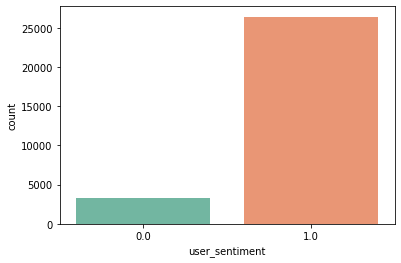

In [156]:
sns.countplot(x='user_sentiment',
              data=df_clean,
              palette='Set2')

In [160]:
df_clean.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_username',
       'user_sentiment'],
      dtype='object')

In [192]:
from collections import Counter
brands_dict = dict(Counter(df_clean['brand']))
brands_count= {key: value for key, value in sorted(brands_dict.items(), 
               key=lambda item: item[1], reverse=True)}
    

brands_count

{'Clorox': 10564,
 'Warner Home Video': 3324,
 'Disney': 1197,
 "L'oreal Paris": 1186,
 'FOX': 887,
 "Burt's Bees": 881,
 'Sony Pictures': 845,
 'Summit Entertainment': 813,
 'Nexxus': 691,
 'Universal Home Video': 668,
 'Olay': 637,
 'Warner Bros.': 458,
 'Lundberg': 414,
 'Clear Scalp & Hair Therapy': 370,
 'Hoover': 349,
 'Windex': 348,
 'Avery': 314,
 'Pendaflex': 310,
 'Aveeno': 302,
 'Tostitos': 286,
 'Storkcraft': 264,
 'Vaseline': 253,
 'Just For Men': 224,
 'Warner Music Group': 204,
 'Hormel': 196,
 'Lionsgate': 186,
 "Chester's": 177,
 'Coty': 158,
 'Lysol': 155,
 'Pantene': 154,
 'Pleasant Hearth': 110,
 'Cuisinart': 103,
 'Bisquick': 96,
 'Vicks': 96,
 "L'Oreal Paris": 94,
 'Head & Shoulders': 92,
 'Aussie': 89,
 'Bounce': 87,
 'Banana Boat': 72,
 'Chips Ahoy': 69,
 'Caress': 68,
 'Yes to Carrots': 63,
 'Cheetos': 60,
 'Ragu': 59,
 'TRESemme': 57,
 'Axe': 57,
 'Suave': 50,
 'Meguiars': 49,
 'Orajel': 46,
 "Mrs. Meyer's": 44,
 'Canada Dry': 43,
 'Finish': 42,
 'Sony Music':

<AxesSubplot:xlabel='reviews_rating', ylabel='count'>

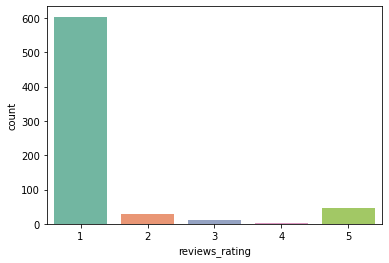

In [194]:
df_nexxus = df_clean[df_clean['brand'] == 'Nexxus']
(sns.countplot(x='reviews_rating', 
              data=df_nexxus,
              palette='Set2') )


<AxesSubplot:xlabel='user_sentiment', ylabel='count'>

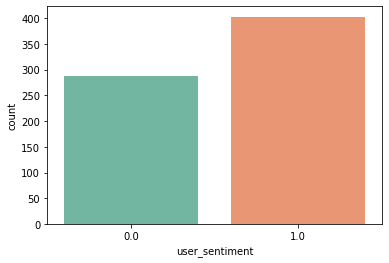

In [195]:
df_nexxus = df_clean[df_clean['brand'] == 'Nexxus']
(sns.countplot(x='user_sentiment', 
              data=df_nexxus,
              palette='Set2') )

In [193]:
# user_sentiment is positive and reviews_rating is less than 4(i.e 3 or less)
df_nexxus[(df_nexxus["user_sentiment"]==1) & (df_nexxus["reviews_rating"]<4)][["brand","reviews_title","reviews_text", "reviews_rating"]].sample(3)


,brand,reviews_title,reviews_text,reviews_rating
21751,Nexxus,Bring back the old formula,"I have been using this for many years and loved it. However, the new formula smells terrible and the hold is not as strong... what happened Bring back the old formula. I have started looking for alternative products.",2
21143,Nexxus,Poo,Have been using Nexxus sculpting gel for maybe 3/4 years and now in 2017 you changed your formula and I don't appreciate the product any longer. New formula makes my hair stiff and difficult to comb and style after use. Want to know how could I possibly get the old product back as it was perfect...,1
21222,Nexxus,Terribly Disappointed!,I've relied on the old formula for 20 years to create body for my baby-fine straight hair. The new formula does not do the trick. I'll have to try other brands until I find a gel comparable to the old formula.,1


In [196]:
pd.crosstab(df_nexxus['user_sentiment'], df_nexxus['reviews_rating'], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0.0,272,12,2,1,1,288
1.0,331,17,8,3,44,403
All,603,29,10,4,45,691


In [197]:
pd.crosstab(df_clean['user_sentiment'], df_clean['reviews_rating'], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0.0,585,137,217,548,1848,3335
1.0,776,272,1115,5444,18805,26412
All,1361,409,1332,5992,20653,29747


As per the above results, there looks to be mismtach between review_rating and user_sentiment. there are records that have higher user rating but user sentiment is negative and lower user rating but user sentiment is positive. We can either clean up those records or update the target column to the correct user sentiment, so that will be helpful for modelling. Here, updating the user_sentiment to 0 (but was 1) when the reviews_rating is less than 4, and updating the user_sentiment to 1(but was 0), when the reviews_rating is greater than or equal to 4

In [198]:
"""
Updating the user_sentiment so that its relevant to the model
Part of pre-processing
"""


df_clean.loc[(df_clean["user_sentiment"]==1) & (df_clean["reviews_rating"]<4), "user_sentiment"] = 0
df_clean.loc[(df_clean["user_sentiment"]==0) & (df_clean["reviews_rating"]>=4), "user_sentiment"] = 1

pd.crosstab(df_clean['user_sentiment'], df_clean['reviews_rating'], margins=True)


reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0.0,1361,409,1332,0,0,3102
1.0,0,0,0,5992,20653,26645
All,1361,409,1332,5992,20653,29747


### Training Analysis


Checking Distribution of *reviews_rating* column¶


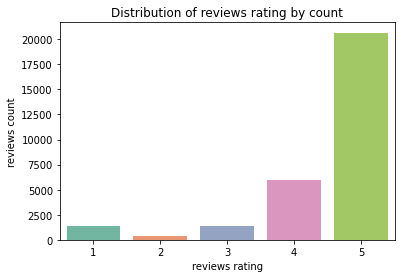

In [144]:
sns.countplot(x = 'reviews_rating', 
              data = df_clean,
              palette= 'Set2').set(title="Distribution of reviews rating by count", 
                                                         xlabel="reviews rating", 
                                                         ylabel="reviews count")
plt.show()


Most of the ratings from the users have been on the higher side. Most of the review ratings have been 5. This would surely cause a data imbalance as user_sentiment should be in alignment with the ratings. We will check and handle it later on.

**Checking Top 5 Brands with negative reviews**

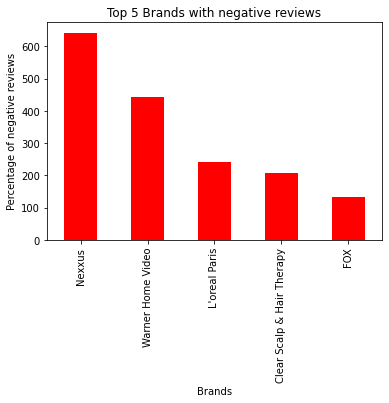

In [202]:
df_clean[ df_clean.user_sentiment == 0].groupby('brand')['brand'].count().sort_values(ascending=False)[:5].plot(kind='bar',color='red')
plt.title("Top 5 Brands with negative reviews")
plt.xlabel("Brands")
plt.ylabel("Percentage of negative reviews")
plt.show()

**Clorox** is the product that is rated the most negative and nearly 30% of the negative reviews have been towards Clorox.



#### Checking Top 5 Brands with positive reviews¶


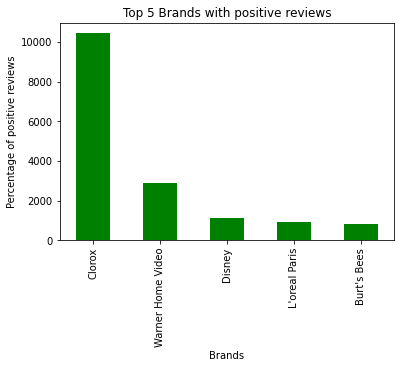

In [201]:
df_clean[ df_clean.user_sentiment == 1 ].groupby('brand')['brand'].count().sort_values(ascending=False)[:5].plot(kind='bar',color='green')
# df_clean[ df_clean.user_sentiment == 0 ].brand.value_counts(normalize=True, ascending=False).head(5).plot(kind='bar')

plt.title("Top 5 Brands with positive reviews")
plt.xlabel("Brands")
plt.ylabel("Percentage of positive reviews")
plt.show()

<AxesSubplot:xlabel='manufacturer'>

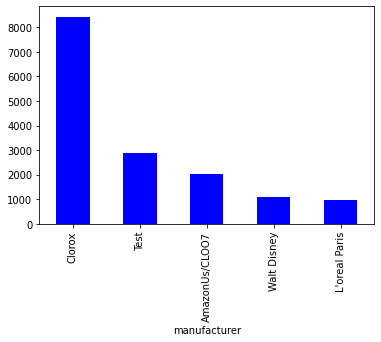

In [206]:
df_clean[ df_clean.user_sentiment == 1 ].groupby('manufacturer')['manufacturer'].count().sort_values(ascending=False)[:5].plot(kind='bar',color='blue')


In [151]:
df_clean.brand.value_counts(normalize=True).head(5)


Clorox              0.36
Warner Home Video   0.11
Disney              0.04
L'oreal Paris       0.04
FOX                 0.03
Name: brand, dtype: float64

* Surprisingly Clorox is the product that is rated the most positive as well and more than 35% of the positive reviews have been towards Clorox.

* Checking the data, we realize that 35% of the brands for which we have the data is actually Clorox which is why it has the most reviews.

#### Type Conversion
Before we start the pre-processing steps, we need to make sure that all the text columns are converted to string type for future text operations.


In [152]:
# Convert all the text columns to string for performing text operations

columns_to_str = ['brand', 'categories', 'manufacturer', 'name',
                  'reviews_text', 'reviews_title', 'reviews_username']
for column in columns_to_str:
    df_clean[column] = df_clean[column].astype(str)
df_clean.sample(2)


,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
8924,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Clea...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,2015-01-09T21:38:14.000Z,5,teacher really appreciates it when I send them to school This review was collected as part of a promotion.,Schools,lilang8833,1.00
3439,AVpe5s3RLJeJML43x4eA,Pantene,"Personal Care,Hair Care,Conditioner,Beauty,Shampoo & Conditioner,Conditioners,Back To College,Ways To Shop,See more Pantene Expert Pro-v Age Defy Conditioner 8oz ...",Pantene Pro-V Hair Care,Pantene Pro-V Expert Collection Age Defy Conditioner,2016-05-10T00:00:00.000Z,5,"I've been using Age Defy - Pantene Expert Collection conditioner for 2 weeks now and my hair is literally coming back to life! It feels so soft and is shining now and also feels stronger, the conditioner is super tick creamy and i use a lot less amount than i used to with another competitive bra...",Age Defy - Pantene Expert Collection Conditioner,mandre86,1.00


### Pre - Processing

In [271]:
# Get a copy of dataframe for pre-processing
df_prep = df_clean.copy(deep=True)
df_prep.sample(1)

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
10883,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Clea...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,2014-12-05T00:00:00.000Z,5,Great product!! I care for my 91 year old mother and these wipes have been a wonderful help in so many ways. I primarily keep them in the bathroom where I use them every day for quick messes. I also like to use them in the kitchen to keep my counter tops extra clean. They have a nice scent and a...,Clorox Disinfecting Wipes are Great!,bettyhop,1.00


Combining reviews_text and reviews_title columns into reviews_combined and dropping the initial fields

In [272]:
df_prep['reviews_combined'] = df_prep['reviews_text'] + " " + df_prep['reviews_title'] + "."
df_prep.drop(columns=['reviews_text', 'reviews_title'], inplace=True)

In [273]:
df_prep.shape

(29748, 10)

In [274]:
df_prep.sample()

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_username,user_sentiment,reviews_combined
22684,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy,"Personal Care,Hair Care,Shampoo,Featured Brands,Health & Beauty,Unilever,Beauty,Shampoo & Conditioner,Shampoos,Hair Care & Styling,Shampoos & Conditioners,Ways To Shop",Clear,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,2016-02-10T14:56:35.000Z,5,barbb,1.00,I didn't know what to expect when I first tried these products but as soon as I started to pour out the shampoo I couldn't believe how thick and rich it was. I knew I was on to something good. The shampoo left my hair feeling so soft and easy to manage. The conditioner was a surprise too. Not th...



**Removing columns unneeded for analysis**

In [275]:
df_prep.drop(columns=['categories', 'manufacturer', 'reviews_date'], inplace=True)


In [276]:
df_prep.sample()

,id,brand,name,reviews_rating,reviews_username,user_sentiment,reviews_combined
19672,AVpfJP1C1cnluZ0-e3Xy,Clorox,Clorox Disinfecting Bathroom Cleaner,5,yohnie1,1.00,clorox wipes are great for the bathroom and kitchen. i keep them everywhere around the house. i also love the various scents that are available. love these wipes.


**Creating dataframe for Sentiment analysis with only the required columns**

In [277]:
df_sent = df_prep[['id','name','reviews_combined', 'user_sentiment']]


In [278]:
df_sent.shape

(29748, 4)

In [279]:
df_sent.sample()

,id,name,reviews_combined,user_sentiment
8770,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Great products! i enjoyed each product and use them everyday. This review was collected as part of a promotion. Clorox Wipes.,1.00


**Handling punctuations**

In [281]:
df_sent['reviews_cleaned'] = df_sent['reviews_combined'].apply(clean_punctuation)
df_sent.sample()

,id,name,reviews_combined,user_sentiment,reviews_cleaned
25646,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,My son will love it when he opens his Christmas presents. He is a big fan of Godzilla movies. I purchased this Godzilla movie for Christmas..,1.00,my son will love it when he opens his christmas presents he is a big fan of godzilla movies i purchased this godzilla movie for christmas


In [269]:
# #Get all the stopwords from the text
# stopwords_set = set(stopwords.words("english"))
# print(stopwords_set)

In [282]:
df_sent['reviews_stopwords_cleaned'] = df_sent['reviews_cleaned'].apply(clean_stopwords)

In [283]:
df_sent.sample(2)

,id,name,reviews_combined,user_sentiment,reviews_cleaned,reviews_stopwords_cleaned
22631,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,this product is great. it leaves my hair soft but yet manageable! This review was collected as part of a promotion. great stuff.,1.00,this product is great it leaves my hair soft but yet manageable this review was collected as part of a promotion great stuff,product great leaves hair soft yet manageable review collected part promotion great stuff
8819,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,We go through Clorox wipes like crazy!!! I have a canister in each of our 3 bathrooms at all times. I also keep travel packs in our vehicle and 1 in my purse. I always keep a canister or 2 under the kitchen sink. Sometimes I have to go look for the one under the sink because my 16 yr old son use...,1.00,we go through clorox wipes like crazy i have a canister in each of our 3 bathrooms at all times i also keep travel packs in our vehicle and 1 in my purse i always keep a canister or 2 under the kitchen sink sometimes i have to go look for the one under the sink because my 16 yr old son uses them...,go clorox wipes like crazy canister 3 bathrooms times also keep travel packs vehicle 1 purse always keep canister 2 kitchen sink sometimes go look one sink 16 yr old son uses keep tennis shoes clean couldnt live without clorox wipes thank great product best product market


**Handling Lemmatization**

In [304]:
class Lemma(object):
    def __init__(self):
        pass

    # This is a helper function to map NTLK position tags
    def get_wordnet_pos(self,tag):
        if tag.startswith('J'):
            return wn.ADJ
        elif tag.startswith('V'):
            return wn.VERB
        elif tag.startswith('N'):
            return wn.NOUN
        elif tag.startswith('R'):
            return wn.ADV
        else:
            return wn.NOUN

    def remove_stopword(self,text):
        stop_words = set(stopwords.words('english'))
        words = [word for word in text.split() if word.isalpha() and word not in stop_words]
        return " ".join(words)

    # Lemmatize the sentence
    def clean_lemma(self,text):
        lemmatizer = WordNetLemmatizer()
        word_pos_tags = nltk.pos_tag(word_tokenize(self.remove_stopword(text))) # Get position tags
        # Map the position tag and lemmatize the word/token
        words =[lemmatizer.lemmatize(tag[0], self.get_wordnet_pos(tag[1])) 
                for _, tag in enumerate(word_pos_tags)] 
        return " ".join(words)
    


In [306]:
df_sent['reviews_lemmatized'] = df_sent['reviews_stopwords_cleaned'].apply(Lemma().clean_lemma)

In [300]:
df_sent.sample()

,id,name,reviews_combined,user_sentiment,reviews_cleaned,reviews_stopwords_cleaned,reviews_lemmatized
13531,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Love the product. I use it for everything, especially when I handle meats, such as chicken.. I wipe down the cutting boards and the counters with this. Work in Progess.",1.00,love the product i use it for everything especially when i handle meats such as chicken i wipe down the cutting boards and the counters with this work in progess,love product use everything especially handle meats chicken wipe cutting boards counters work progess,love product use everything especially handle meat chicken wipe cutting board counter work progess


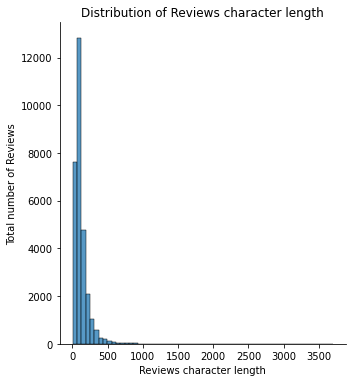

In [307]:
# Visualizing 'reviews_lemmatized' character length
character_length = [len(each_sent) for each_sent in df_sent['reviews_lemmatized']]

sns.displot(character_length, kind='hist', bins=60)
plt.xlabel("Reviews character length")
plt.ylabel("Total number of Reviews")
plt.title("Distribution of Reviews character length")
plt.show()

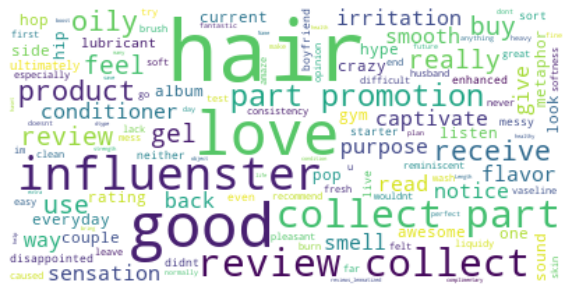

In [310]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#Using a word cloud visualize the top 30 words in review by frequency
stopwords_wordcloud = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=200, 
                      background_color="white", random_state=42, 
                      stopwords=stopwords_wordcloud).generate(str(df_sent['reviews_lemmatized']))
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [311]:
import string
def getMostCommonWords(reviews, n_most_common):
    # flatten review column into a list of words, and set each to lowercase
    flattened_reviews = [word for review in reviews for word in \
                         review.lower().split()]


    # remove punctuation from reviews
    flattened_reviews = [''.join(char for char in review if \
                                 char not in string.punctuation) for \
                         review in flattened_reviews]


    # remove any empty strings that were created by this process
    flattened_reviews = [review for review in flattened_reviews if review]

    return Counter(flattened_reviews).most_common(n_most_common)

In [316]:
pos_reviews = df_sent[df_sent['user_sentiment']==1]
neg_reviews = df_sent[df_sent['user_sentiment']==0]

getMostCommonWords(pos_reviews['reviews_lemmatized'],10), getMostCommonWords(neg_reviews['reviews_lemmatized'],10)

([('great', 14347),
  ('love', 12382),
  ('use', 11694),
  ('product', 10749),
  ('movie', 9849),
  ('review', 8880),
  ('part', 8722),
  ('promotion', 8374),
  ('wipe', 8215),
  ('collect', 7945)],
 [('product', 1915),
  ('use', 1788),
  ('hair', 1544),
  ('formula', 1440),
  ('new', 1260),
  ('old', 1078),
  ('good', 1070),
  ('like', 1065),
  ('movie', 1032),
  ('gel', 874)])

In [317]:
#function to collect the n-gram frequency of words
def get_top_n_ngram( corpus, n_gram_range ,n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [318]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(pos_reviews['reviews_lemmatized'], 2, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 1]]


,0,1
0,review collect,7921
1,collect promotion,7921
2,clorox wipe,2805
3,great product,1901
4,great movie,1725
5,easy use,1541
6,promotion great,1306
7,love clorox,1203
8,love product,1112
9,promotion love,1100


In [319]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(neg_reviews['reviews_lemmatized'], 2, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 2]]


,0,1
0,new formula,520
1,old formula,515
2,bring old,370
3,review collect,345
4,collect promotion,345
5,exxtra gel,205
6,use product,179
7,make hair,156
8,shampoo conditioner,147
9,receive product,127


### Feature Extraction

In this part, we will be performing

1. Feature Extraction using TF-IDF
2. Check for and handle Class imbalance
3. Perform train, test split

Feature Extraction using **TF-IDF** Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words" max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently min_df = 5 means "ignore terms that appear in less than 5 complaints"



In [331]:
df_sent.user_sentiment.fillna(1, inplace=True)


In [333]:
# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, stop_words='english', ngram_range=(1,2))

In [334]:
X = tfidf.fit_transform(df_sent['reviews_lemmatized'])

y= df_sent['user_sentiment']

Train - Test Split

In [335]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (22311, 16199) (22311,)
Test shapes: (7437, 16199) (7437,)


Class Imbalance

In [336]:
# Check the data to see if there is a class imbalance in the data
df_sent['user_sentiment'].value_counts(normalize=True)

1.00   0.90
0.00   0.10
Name: user_sentiment, dtype: float64

From the results above, we can concluded that there is a heavy class imbalance prevalent in the data.

Positive sentiments make up 89% of the data and Negative sentiments make up only 11%

We are going to handle the imbalance using a technique called SMOTE (Synthetic Minority Oversampling Technique)
This is an oversampling method that generates synthetic samples for the minority class

In [337]:
counter = Counter(y_train)
print("Before handling imbalance", counter)

#oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print("After handling imbalance", counter)

Before handling imbalance Counter({1.0: 19967, 0.0: 2344})
After handling imbalance Counter({1.0: 19967, 0.0: 19967})


**Both the positive and negative sentiments now have equal no of rows.**

### Model Building

We will be creating the following three ML models based on performance for predicting the sentiments based on the text and title of the reviews:

1. Random Forest
2. XGBoost

In [338]:
# Function to display scores
def evaluation_scores(classifier, X_test, y_test):

  # Calculating Predicted value
  y_pred = classifier.predict(X_test)

  # Create confusion matrix
  conf_m = confusion_matrix(y_test, y_pred)

  print("Visualizing the Confusion Matrix with a Heatmap")
  print("\n")
  print("*"*50)
  # Visualize Confusion Matrix with heatmap
  fig, ax = plt.subplots(figsize=(6, 6))
  ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                  annot=True,
                  cbar=False,
                  cmap="RdYlGn", fmt = '0.1f')
  plt.xlabel("Actual label")
  plt.ylabel("Predicted label")
  plt.show()
  print("*"*50)
  print("\n")

  # Calculating the values of True Positives, True Negatives, False Positivies and False Negatives
  TP = conf_m[1][1]
  TN = conf_m[0][0]
  FP = conf_m[0][1]
  FN = conf_m[1][0]

  print("Values of True Positives, True Negatives, False Positivies and False Negatives")
  print("~"*50)
  print('True Positives:', TP)
  print('True Negatives:', TN)
  print('False Positives:', FP)
  print('False Negatives:', FN)
  print("~"*50)
  print("\n")

  # Calculating Accuracy
  accuracy = accuracy_score(y_test, y_pred)
  accuracy = round(accuracy,2)
  
  # Calculating Sensitivity/Recall
  sensitivity_recall = (TP / float(TP + FN))
  sensitivity_recall = round(sensitivity_recall,2)
  
  # Calculating Specificity
  specificity = (TN / float(TN + FP))
  specificity = round(specificity,2)  
  
  # Calculating Precision
  precision = (TN / float(TN + FP))
  precision = round(precision,2)  
  
  # Calculating F_1 score
  F1_score = 2 * ((precision * sensitivity_recall) / (precision + sensitivity_recall))
  F1_score = round(F1_score,2)  
  
  print("Evaluation Score Summary")
  print('-'*50)
  print(f'Accuracy Score: {round(accuracy,2)}')
  print(f'Sensitivity/Recall Score: {round(sensitivity_recall,2)}') 
  print(f'Specificity Score: {round(specificity,2)}') 
  print(f'Precision: {round(precision,2)}')
  print(f'F1 Score: {round(F1_score,2)}')
  print('-'*50)

  # Returning evaluation results for comparison later
  evaluation_metrics = []
  evaluation_metrics.append(accuracy)
  evaluation_metrics.append(sensitivity_recall)
  evaluation_metrics.append(specificity)
  evaluation_metrics.append(precision)
  evaluation_metrics.append(F1_score)
  
  return evaluation_metrics

#### Base Model


In [339]:
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train_sm, y_train_sm)


Visualizing the Confusion Matrix with a Heatmap


**************************************************


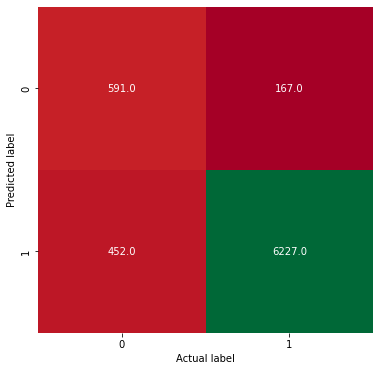

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6227
True Negatives: 591
False Positives: 167
False Negatives: 452
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.92
Sensitivity/Recall Score: 0.93
Specificity Score: 0.78
Precision: 0.78
F1 Score: 0.85
--------------------------------------------------


In [341]:
#Getting the score from the base model
lr_metrics = evaluation_scores(logreg, X_test, y_test)

In [342]:
# Printing the scores of the base model as reference
df_lrb_metrics = pd.DataFrame({'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 'Logistic Regression Base Model': lr_metrics},
                             columns = ['Metrics', 'Logistic Regression Base Model']
                             )
df_lrb_metrics

,Metrics,Logistic Regression Base Model
0,Accuracy,0.92
1,Sensitivity/Recall,0.93
2,Specificity,0.78
3,Precision,0.78
4,F1 Score,0.85


#### Random Forest Classifier

In [343]:
rf = RandomForestClassifier(random_state=42).fit(X_train_sm, y_train_sm)


Visualizing the Confusion Matrix with a Heatmap


**************************************************


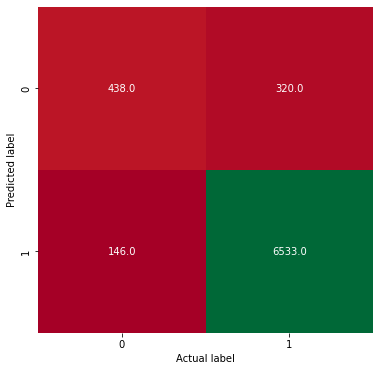

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6533
True Negatives: 438
False Positives: 320
False Negatives: 146
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.94
Sensitivity/Recall Score: 0.98
Specificity Score: 0.58
Precision: 0.58
F1 Score: 0.73
--------------------------------------------------


In [344]:
rf_metrics = evaluation_scores(rf, X_test, y_test)

In [345]:
# Printing the scores of the base model as reference
df_rfb_metrics = pd.DataFrame({'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 'RF Base Model': rf_metrics},
                             columns = ['Metrics', 'RF Base Model']
                             )
df_rfb_metrics

,Metrics,RF Base Model
0,Accuracy,0.94
1,Sensitivity/Recall,0.98
2,Specificity,0.58
3,Precision,0.58
4,F1 Score,0.73


Sensitivity and Accuracy are high but Specificity and Precision are low. Let's perform hyperparameter tuning and see if we can improve the scores.

**Hyperparameter Tuning**

In [346]:
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": np.arange(10, 50, 5),
           "min_samples_split": np.arange(15, 500, 15),
           "min_samples_leaf": np.arange(5, 50, 5)}

In [348]:
# Setup random hyperparameter search for Random Forest Classifier
rf_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                scoring='f1')

# Fit random hyperparameter search model
rf_hpt.fit(X_train_sm, y_train_sm);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [349]:
# Check best parameters
rf_hpt.best_params_

{'n_estimators': 610,
 'min_samples_split': 15,
 'min_samples_leaf': 20,
 'max_depth': 30}

Visualizing the Confusion Matrix with a Heatmap


**************************************************


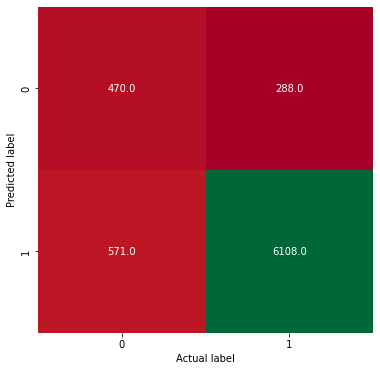

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6108
True Negatives: 470
False Positives: 288
False Negatives: 571
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.88
Sensitivity/Recall Score: 0.91
Specificity Score: 0.62
Precision: 0.62
F1 Score: 0.74
--------------------------------------------------


[0.88, 0.91, 0.62, 0.62, 0.74]

In [350]:
evaluation_scores(rf_hpt, X_test, y_test)

Visualizing the Confusion Matrix with a Heatmap


**************************************************


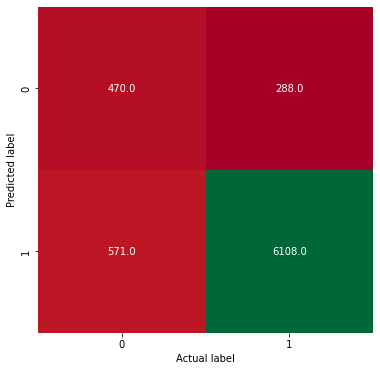

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6108
True Negatives: 470
False Positives: 288
False Negatives: 571
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.88
Sensitivity/Recall Score: 0.91
Specificity Score: 0.62
Precision: 0.62
F1 Score: 0.74
--------------------------------------------------


In [351]:
# Getting the scores of the tuned model
rf_tuned_metrics = evaluation_scores(rf_hpt, X_test, y_test)

In [352]:
# Printing the scores of the base and tuned Random Forest model as reference
dict_rf_bt_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 
                               'RF Base Model': rf_metrics,
                               'RF Tuned Model': rf_tuned_metrics}

df_rf_bt_metrics = pd.DataFrame(dict_rf_bt_metrics, columns = ['Metrics', 'RF Base Model', 'RF Tuned Model'])
df_rf_bt_metrics

,Metrics,RF Base Model,RF Tuned Model
0,Accuracy,0.94,0.88
1,Sensitivity/Recall,0.98,0.91
2,Specificity,0.58,0.62
3,Precision,0.58,0.62
4,F1 Score,0.73,0.74


#### Model Evaluation

In [354]:
# Printing the scores of all the 3 Models (Base and Tuned)
dict_bt_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'],
                              'LR Base Model': lr_metrics, 
                              'RF Base Model': rf_metrics, 
                              'RF Tuned Model': rf_tuned_metrics,
                              }

df_bt_metrics = pd.DataFrame(dict_bt_metrics, columns = ['Metrics', 'LR Base Model','RF Base Model', 'RF Tuned Model'])
df_bt_metrics

,Metrics,LR Base Model,RF Base Model,RF Tuned Model
0,Accuracy,0.92,0.94,0.88
1,Sensitivity/Recall,0.93,0.98,0.91
2,Specificity,0.78,0.58,0.62
3,Precision,0.78,0.58,0.62
4,F1 Score,0.85,0.73,0.74


Looking at the model evaluation metrics and focusing on Sensitivity, Specificity and F1 Score, we can conclude that the base Logistic Regression Model is the best model out of all of them.

In [359]:
def save_model(model, filename):
    filename = filename+'.pkl'
    pickle.dump(model, open(filename, 'wb'))


In [360]:
save_model(logreg, 'sentiment_classification_logreg_model')